In [ ]:
!pip install torchaudio librosa boto3
import torchaudio
import torch

     |████████████████████████████████| 1.9MB 8.2MB/s 
     |████████████████████████████████| 133kB 54.2MB/s 
     |████████████████████████████████| 81kB 12.0MB/s 
     |████████████████████████████████| 7.6MB 51.9MB/s 
     |████████████████████████████████| 143kB 51.9MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import pandas as pd

In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt


In [ ]:
import os
from pathlib import Path

In [ ]:
!gdown https://drive.google.com/uc?id=1iVEgEKm1tS1upClYWih6ikEiwd8mh0Vm

Downloading...
From: https://drive.google.com/uc?id=1iVEgEKm1tS1upClYWih6ikEiwd8mh0Vm
To: /content/voice_print.zip
2.01GB [00:35, 56.5MB/s]


In [ ]:
!unzip -q voice_print

In [ ]:
data = pd.read_csv("/content/voice_print.csv")

In [ ]:
data.count()

label          26941
mode           26941
name           26941
sample_rate    26941
voiceprint     26941
dtype: int64

In [ ]:
data_test = data.loc[data['mode'] == 'test']

In [ ]:
X_test, y_test = data_test.voiceprint, data_test.label

In [ ]:
data_train = data.loc[data['mode'] == 'train']

In [ ]:
data_valid = data.loc[data['mode'] == 'valid']

In [ ]:
X_valid, y_valid = data_valid.voiceprint, data_valid.label

In [ ]:
X_train, y_train = data_train.voiceprint, data_train.label

In [ ]:
def get_mfcc(amplitudes, labels):
  X = []
  y = []
  for amp in amplitudes:
    amp = torch.from_numpy(np.array(amp[1:-1].split(","), dtype=np.float32)).view(1, 8000)
    lowpass = [
            ['gain', '-n'],
      ["overdrive",  "10"] # apply single-pole lowpass filter
                        # This only changes sample rate, so it is necessary to
                        # add `rate` effect with original sample rate after this.
    ]
    # highpass = [
    #   ["highpass", "-1", "4000"]# apply single-pole lowpass filter
    #                     # This only changes sample rate, so it is necessary to
    #                     # add `rate` effect with original sample rate after this.
    # ]

    # waveform, sample_rate = torchaudio.sox_effects.apply_effects_tensor(
    #     amp, 8000, lowpass)
    #mfcc = torchaudio.transforms.MFCC(8000, 40, log_mels=True, melkwargs={'n_fft' : 512, 'n_mels':40, 'win_length' : 200, 'hop_length' :80, 'f_min': 70.0, 'f_max': 4000.0})(waveform)
    # X.append(mfcc)
    mfcc = torchaudio.transforms.MFCC(8000, 120, log_mels=True, melkwargs={'n_fft' : 512, 'n_mels':120, 'win_length' : 200, 'hop_length' :80, 'f_min': 70.0, 'f_max': 4000.0})(amp)
    # deltas = torchaudio.transforms.ComputeDeltas(50)(mfcc)
    X.append(mfcc)

  for label in labels:
    y.append(label)
    # y.append(label)
  return X, y

In [ ]:
X_train_mfcc, y_train_mfcc  = get_mfcc(X_train, y_train)
X_valid_mfcc, y_valid_mfcc = get_mfcc(X_valid, y_valid)

In [ ]:
X_train_mfcc = torch.cat(X_train_mfcc)
X_valid_mfcc = torch.cat(X_valid_mfcc)

In [ ]:
y_train_mfcc = torch.LongTensor(y_train_mfcc)
y_valid_mfcc = torch.LongTensor(y_valid_mfcc)

In [ ]:
def generate_batches(X, y, batch_size=64):
    assert len(X) == len(y)
    np.random.seed(42)
    perm = np.random.permutation(len(X))
    for start in range(0, (len(X)//batch_size)*batch_size, batch_size):
      end = min(start + batch_size, len(X))
      batch_idx = perm[start:end]
      yield X[batch_idx], y[batch_idx]

# CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, tqdm_notebook

In [ ]:
class VoiceCnn(nn.Module):
  #  [128, 1, 80], expected input[256, 128, 150]
    def __init__(self, n_classes):
          super().__init__()
          self.conv1 = nn.Conv1d(120, 64, 2, 2)
          self.bn1 = nn.BatchNorm1d(64)
          self.conv2 = nn.Conv1d(64, 128, 1)
          self.bn2 = nn.BatchNorm1d(128)
          self.pool1 = nn.MaxPool1d(2, 2)


          self.conv3 = nn.Conv1d(128, 256, 1)
          self.bn3 = nn.BatchNorm1d(256)
          self.conv4 = nn.Conv1d(256, 512, 1)
          self.bn4 = nn.BatchNorm1d(512)
          self.pool2 = nn.MaxPool1d(2, 2)
          self.dropout4 = nn.Dropout(p=0.2)

          self.conv5 = nn.Conv1d(512, 512, 1)
          self.bn5 = nn.BatchNorm1d(512)
          self.conv6 = nn.Conv1d(512, 768, 1)
          self.bn6 = nn.BatchNorm1d(768)
          self.pool3 = nn.MaxPool1d(2, 2)


          self.conv7 = nn.Conv1d(768, 1024, 1)
          self.bn7 = nn.BatchNorm1d(1024)
          self.conv8 = nn.Conv1d(1024, 768, 1)
          self.bn8 = nn.BatchNorm1d(768)
          self.pool4 = nn.MaxPool1d(2, 2)
          self.dropout5 = nn.Dropout(p=0.2)

          self.conv9 = nn.Conv1d(768, 1024, 1)
          self.bn9 = nn.BatchNorm1d(1024)
          self.conv10 = nn.Conv1d(1024, 1536, 1)
          self.bn10 = nn.BatchNorm1d(1536)

          self.conv11 = nn.Conv1d(1536, 2048, 1)
          self.bn11 = nn.BatchNorm1d(2048)
          self.pool7 = nn.AvgPool1d(2,  2)

          self.fc1 = nn.Linear(2048, 4096)
          self.dropout1 = nn.Dropout(p=0.2)
          self.fc2 = nn.Linear(4096, 8192)
          self.dropout2 = nn.Dropout(p=0.2)
          self.fc3 = nn.Linear(8192, n_classes*10 )
          self.dropout3 = nn.Dropout(p=0.2)
          self.out = nn.Linear(n_classes*10, n_classes)
          
    def forward(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(self.bn1(x))
        x = self.conv2(x)
        x = F.leaky_relu(self.bn2(x))
        x = self.pool1(x)

        x = self.conv3(x)
        x = F.leaky_relu(self.bn3(x))
        x = self.conv4(x)
        x = F.leaky_relu(self.bn4(x))
        x = self.pool2(x)
        x = self.dropout4(x)

        x = self.conv5(x)
        x = F.leaky_relu(self.bn5(x))
        x = self.conv6(x)
        x = F.leaky_relu(self.bn6(x))
        x = self.pool3(x)

        x = self.conv7(x)
        x = F.leaky_relu(self.bn7(x))
        x = self.conv8(x)
        x = F.leaky_relu(self.bn8(x))
        x = self.pool4(x)
        x = self.dropout5(x)

        x = self.conv9(x)
        x = F.leaky_relu(self.bn9(x))
        x = self.conv10(x)
        x = F.leaky_relu(self.bn10(x))      
        x = self.conv11(x)
        x = F.leaky_relu(self.bn11(x))
        x = self.pool7(x)
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.dropout3(x)
        logits = self.out(x)
        return logits



In [ ]:
print(VoiceCnn(206))

VoiceCnn(
  (conv1): Conv1d(128, 64, kernel_size=(4,), stride=(2,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
  (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv1d(512, 768, kernel_size=(1,), stride=(1,))
  (bn6): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Co

In [ ]:
def fit_epoch(model, X_train, y_train,  criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    for inputs, labels in generate_batches(X_train, y_train):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # inputs = torch.from_numpy(inputs).to(device, dtype=torch.float)
        # labels = torch.from_numpy(labels).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, X_valid, y_valid, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in generate_batches(X_valid, y_valid):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # inputs = torch.from_numpy(inputs).to(device, dtype=torch.float)
        # labels = torch.from_numpy(labels).to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(X_train, y_train, X_valid, y_valid, model, epochs):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        #opt = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.8, nesterov=True)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, X_train, y_train, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, X_valid, y_valid, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
n_classes = len(np.unique(y_train))
voice_cnn = VoiceCnn(n_classes).to(device)
history = train(X_train_mfcc, y_train_mfcc, X_valid_mfcc, y_valid_mfcc, model=voice_cnn, epochs=30)

cuda


epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 10.146657267812849


epoch:   3%|▎         | 1/30 [00:26<12:55, 26.72s/it]


Epoch 001 train_loss: 10.1467     val_loss 4.8989 train_acc 0.1653 val_acc 0.2321
loss 3.5496531327565513


epoch:   7%|▋         | 2/30 [00:54<12:35, 26.99s/it]


Epoch 002 train_loss: 3.5497     val_loss 3.1654 train_acc 0.2903 val_acc 0.3237
loss 2.9059713280240302


epoch:  10%|█         | 3/30 [01:21<12:13, 27.16s/it]


Epoch 003 train_loss: 2.9060     val_loss 2.7358 train_acc 0.3570 val_acc 0.3617
loss 2.5409904836428048


epoch:  13%|█▎        | 4/30 [01:49<11:49, 27.31s/it]


Epoch 004 train_loss: 2.5410     val_loss 2.3791 train_acc 0.4050 val_acc 0.4279
loss 2.289174671613737


epoch:  17%|█▋        | 5/30 [02:17<11:24, 27.39s/it]


Epoch 005 train_loss: 2.2892     val_loss 2.2085 train_acc 0.4468 val_acc 0.4582
loss 2.039161216701218


epoch:  20%|██        | 6/30 [02:44<10:59, 27.46s/it]


Epoch 006 train_loss: 2.0392     val_loss 1.9352 train_acc 0.4865 val_acc 0.5080
loss 1.8780876878071147


epoch:  23%|██▎       | 7/30 [03:12<10:32, 27.49s/it]


Epoch 007 train_loss: 1.8781     val_loss 1.7591 train_acc 0.5219 val_acc 0.5479
loss 1.6932479937871296


epoch:  27%|██▋       | 8/30 [03:39<10:05, 27.53s/it]


Epoch 008 train_loss: 1.6932     val_loss 1.5576 train_acc 0.5567 val_acc 0.5846
loss 1.6211000700594962


epoch:  30%|███       | 9/30 [04:07<09:38, 27.55s/it]


Epoch 009 train_loss: 1.6211     val_loss 1.7082 train_acc 0.5749 val_acc 0.5503
loss 1.489027488939833


epoch:  33%|███▎      | 10/30 [04:35<09:11, 27.57s/it]


Epoch 010 train_loss: 1.4890     val_loss 1.6791 train_acc 0.5995 val_acc 0.5615
loss 1.4094107186440195


epoch:  37%|███▋      | 11/30 [05:02<08:43, 27.57s/it]


Epoch 011 train_loss: 1.4094     val_loss 1.7145 train_acc 0.6174 val_acc 0.5653
loss 1.3886213339988154


epoch:  40%|████      | 12/30 [05:30<08:16, 27.59s/it]


Epoch 012 train_loss: 1.3886     val_loss 1.3610 train_acc 0.6225 val_acc 0.6309
loss 1.2653870964207665


epoch:  43%|████▎     | 13/30 [05:57<07:48, 27.59s/it]


Epoch 013 train_loss: 1.2654     val_loss 1.4460 train_acc 0.6510 val_acc 0.6157
loss 1.2133028078393968


epoch:  47%|████▋     | 14/30 [06:25<07:21, 27.60s/it]


Epoch 014 train_loss: 1.2133     val_loss 1.3474 train_acc 0.6661 val_acc 0.6432
loss 1.1461158609232887


epoch:  50%|█████     | 15/30 [06:53<06:53, 27.59s/it]


Epoch 015 train_loss: 1.1461     val_loss 1.3026 train_acc 0.6858 val_acc 0.6590
loss 1.0693202679700191


epoch:  53%|█████▎    | 16/30 [07:20<06:26, 27.61s/it]


Epoch 016 train_loss: 1.0693     val_loss 1.3338 train_acc 0.6989 val_acc 0.6475
loss 1.0709161048281703


epoch:  57%|█████▋    | 17/30 [07:48<05:58, 27.60s/it]


Epoch 017 train_loss: 1.0709     val_loss 1.4234 train_acc 0.7029 val_acc 0.6483
loss 1.0308325125439333


epoch:  60%|██████    | 18/30 [08:16<05:31, 27.62s/it]


Epoch 018 train_loss: 1.0308     val_loss 1.3767 train_acc 0.7152 val_acc 0.6483
loss 1.0191101831178067


epoch:  63%|██████▎   | 19/30 [08:43<05:03, 27.61s/it]


Epoch 019 train_loss: 1.0191     val_loss 1.3103 train_acc 0.7145 val_acc 0.6582
loss 0.9391117867070062


epoch:  67%|██████▋   | 20/30 [09:11<04:36, 27.61s/it]


Epoch 020 train_loss: 0.9391     val_loss 1.1939 train_acc 0.7352 val_acc 0.6971
loss 0.9001000194069576


epoch:  70%|███████   | 21/30 [09:38<04:08, 27.60s/it]


Epoch 021 train_loss: 0.9001     val_loss 1.2374 train_acc 0.7463 val_acc 0.6919
loss 0.8241177536670131


epoch:  73%|███████▎  | 22/30 [10:06<03:40, 27.61s/it]


Epoch 022 train_loss: 0.8241     val_loss 1.3017 train_acc 0.7672 val_acc 0.6751
loss 0.7952396505736675


epoch:  77%|███████▋  | 23/30 [10:34<03:13, 27.60s/it]


Epoch 023 train_loss: 0.7952     val_loss 1.2933 train_acc 0.7729 val_acc 0.6987
loss 0.7845404310391682


epoch:  80%|████████  | 24/30 [11:01<02:45, 27.60s/it]


Epoch 024 train_loss: 0.7845     val_loss 1.1643 train_acc 0.7782 val_acc 0.7131
loss 0.7830183482406163


epoch:  83%|████████▎ | 25/30 [11:29<02:18, 27.60s/it]


Epoch 025 train_loss: 0.7830     val_loss 1.1271 train_acc 0.7809 val_acc 0.7264
loss 0.720227716877909


epoch:  87%|████████▋ | 26/30 [11:56<01:50, 27.61s/it]


Epoch 026 train_loss: 0.7202     val_loss 1.1051 train_acc 0.7959 val_acc 0.7305
loss 0.783659022830107


epoch:  90%|█████████ | 27/30 [12:24<01:22, 27.60s/it]


Epoch 027 train_loss: 0.7837     val_loss 1.2733 train_acc 0.7842 val_acc 0.7026
loss 0.7250278993408279


epoch:  93%|█████████▎| 28/30 [12:52<00:55, 27.60s/it]


Epoch 028 train_loss: 0.7250     val_loss 1.2258 train_acc 0.7971 val_acc 0.7100
loss 0.7082065139273213


epoch:  97%|█████████▋| 29/30 [13:19<00:27, 27.58s/it]


Epoch 029 train_loss: 0.7082     val_loss 1.2433 train_acc 0.8032 val_acc 0.7142
loss 0.6277074222714201


epoch: 100%|██████████| 30/30 [13:47<00:00, 27.57s/it]


Epoch 030 train_loss: 0.6277     val_loss 1.3651 train_acc 0.8242 val_acc 0.7028


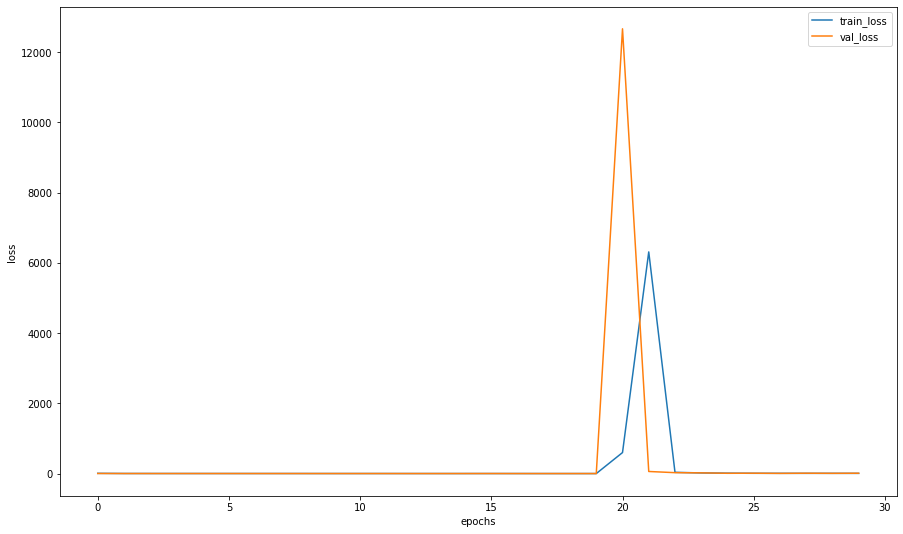

In [ ]:
import matplotlib.pyplot as plt
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15,9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
X_test_mfcc, y_test_mfcc = get_mfcc(X_test, y_test)
X_test_mfcc = torch.cat(X_test_mfcc).unsqueeze(1) 
y_test_mfcc = torch.LongTensor(y_test_mfcc)

In [ ]:
def predict(model, X_test, y_test):
    with torch.no_grad():
        correct = 0
        total = 0 
        expect= []
        preds =[]
        for inputs, labels in zip(X_test, y_test):
            inputs = inputs.to(device, dtype=torch.float)
            model.eval()
            output = model(inputs.unsqueeze(0)).cpu()
            output = torch.exp(output)
            prob = torch.max(output.data, 1)[0].numpy()[0]
            prediction = int(torch.max(output.data, 1)[1].numpy())
            preds.append(prediction)
            expect.append(labels)
    return preds, expect

In [ ]:
p, e = predict(voice_cnn, X_test_mfcc, y_test_mfcc) 
accuracy_score(e, p)

0.8778901734104047

In [ ]:
p[-20:-1]

[202,
 201,
 1,
 202,
 202,
 203,
 115,
 203,
 203,
 204,
 204,
 204,
 204,
 205,
 205,
 205,
 4,
 189,
 205]

In [ ]:
torch.save(voice_cnn.state_dict(), 'voice2D_87_70MFCC.pt')

In [ ]:
results = pd.DataFrame()

In [ ]:
results['labels'] = np.unique(y_train)

In [ ]:
train_sec = []
for label in results.labels:
  train_sec.append(data_train.loc[data_train['label'] == label].count()[0])
valid_sec = []
for label in results.labels:
  valid_sec.append(data_valid.loc[data_valid['label'] == label].count()[0])
test_sec = []
for label in results.labels:
  test_sec.append(data_test.loc[data_test['label'] == label].count()[0])
results['train_sec'] = train_sec
results['valid_sec'] = valid_sec
results['test_sec'] = test_sec

In [ ]:
n_true = [0]*206
for i in range(len(p)):
  if p[i]==e[i]:
    n_true[e[i]]+=1
results['n_true'] = n_true

In [ ]:
results['percent_true'] =  results.n_true/results.test_sec

In [ ]:
results.loc[results['labels'] == 205 ]

,labels,train_sec,valid_sec,test_sec,n_true,percent_true
205,205,58,8,7,5,0.714286


In [ ]:
results.to_csv('results/CNN2D_70MFCC_accuracy_87.csv')

In [ ]:
(results.loc[results['percent_true'] >0.6].train_sec + results.loc[results['percent_true'] >0.6].valid_sec + results.loc[results['percent_true'] >0.6].test_sec).mode()

0    83
dtype: int64

In [ ]:
!zip -r /content/results.zip /content/results

updating: content/results/ (stored 0%)
updating: content/results/CNN2D_70MFCC_accuracy_87.csv (deflated 68%)
  adding: content/results/voice2D_87_70MFCC.pt (deflated 8%)
